Here I process the perplex table I got from Gabe

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import re
from matplotlib import pyplot as plt

# import hamageolib packages and related modules, functions
root_path = os.path.join(Path().resolve().parent.parent.parent)
package_path = os.path.join(root_path, "hamageolib")

if str(package_path) not in sys.path:
    sys.path.insert(0, str(package_path))

import utils.plot_helper as plot_helper # plotting utilities

# Set up

Here I run a self-defined test to get the output of Perple_X table implemented in aspect

In [2]:
aspect_dir = "/home/lochy/Softwares/aspect"
aspect_executable = os.path.join(aspect_dir, "build_master_TwoD/aspect")

model = "perplex"  # model for phase transitions, perplex or CDPT
if model == "perplex":
    prm_template_path = os.path.join(aspect_dir, "tests/TwoDSubduction_perplex_morb_viscosity_mixing.prm")
elif model == "CDPT":
    prm_template_path = os.path.join(aspect_dir, "tests/TwoDSubduction_perplex_morb_viscosity_mixing.prm")
else:
    raise ValueError("Model must be perpelx or CDPT.")

# for the perplex model
mixing_model = 3 # 1: iso stress (weakest), 2: iso strain (strongest), 3: log (intermediate)
# for the CDPT model
cutoff_depth = 50e3

# resolution
n_repetitions = 800 # repitition along X and Y direction, affecting the resolution

assert(os.path.isfile(aspect_executable))
assert(os.path.isfile(prm_template_path))

# assign another directory to run the case
case_root_dir = os.path.join(root_path, "dtemp") 

In [3]:
from shutil import rmtree
from utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
from utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature

case_dir = os.path.join(case_root_dir, "TwoDSubduction_perplex")  # New directory to run the case
if os.path.isdir(case_dir):
    rmtree(case_dir)
os.mkdir(case_dir)

# Modify the template
# Also read important parameters like the size of the model

with open(prm_template_path, 'r') as file:
    params_dict = parse_parameters_to_dict(file)

params_dict["Output directory"] = os.path.join(case_dir, "output")
params_dict["Additional shared libraries"] = os.path.join(aspect_dir, "build_master_TwoD/visco_plastic_TwoD/libvisco_plastic_TwoD.so")

if model == "perplex":
    params_dict["Material model"]["Visco Plastic TwoD"]["Phase rheology mixing models"] = "0, %d, 0, 0, 0" % mixing_model
elif model == "CDPT":
    params_dict["Material model"]["Visco Plastic TwoD"]["Decoupling eclogite viscosity"] = "true"
    params_dict["Material model"]["Visco Plastic TwoD"]["Use lookup table morb"] = "false"
    params_dict["Material model"]["Visco Plastic TwoD"]["Eclogite decoupled viscosity"] = {
        "Decoupled depth": "%.1f" % (cutoff_depth),
        "Decoupled depth width": "10e3"}
else:
    raise ValueError("Model must be perpelx or CDPT.")


params_dict["Geometry model"]["Box"]["X repetitions"] = str(n_repetitions)
params_dict["Geometry model"]["Box"]["Y repetitions"] = str(n_repetitions)

# Write to a prm file in the new case directory
prm_path = os.path.join(case_dir, "case.prm")

with open(prm_path, 'w') as output_file:
    save_parameters_from_dict(output_file, params_dict)

assert(os.path.isfile(prm_path))

print("Created case in %s" % (case_dir))

Created case in /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/TwoDSubduction_perplex


# Run

Use "subprocess.run" to run the case.

Capture the standard output and error streams

Check
  * if the expected line indicating wallclock time appears in the output.
  * There is no stderr output.

In [4]:
import subprocess

# Run the ASPECT executable with the parameter file
# The function ensures that both the expected outputs are generated and no errors are produced
# 'capture_output=True' collects both stdout and stderr for further checks
completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

# Capture the standard output and error streams
stdout = completed_process.stdout
stderr = completed_process.stderr

# Uncomment the following lines for debugging purposes to inspect the output
# print(stdout)  # Debugging: Prints the standard output
print(stderr)  # Debugging: Prints the standard error

# Check if the expected line indicating wallclock time appears in the output
# The expected line format is something like:
# -- Total wallclock time elapsed including restarts: 1s
assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

# Ensure that the error stream is empty, indicating no issues during the run
assert(stderr == "")

# Post-processing

## Read model data

In [5]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from utils.vtk_utilities import calculate_resolution
import time
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

pvtu_file = os.path.join(case_dir, "output", "solution", "solution-00000.pvtu")
assert(os.path.isfile(pvtu_file))

# Read the pvtu file
start = time.time()

reader = vtk.vtkXMLPUnstructuredGridReader()
reader.SetFileName(pvtu_file)
reader.Update()

end = time.time()
print("Initiating reader takes %.2e s" % (end - start))
start = end

# Get the output data from the reader
grid = reader.GetOutput()  # Access the unstructured grid
data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
points = grid.GetPoints()  # Extract the points (coordinates)
cells = grid.GetCells()  # Extract the cell connectivity information
point_data = data_set.GetPointData()  # Access point-wise data

n_points = grid.GetNumberOfPoints() # Number of points and cells
n_cells = grid.GetNumberOfCells()

end = time.time()
print("Reading files takes %.2e s" % (end - start))
print(f"\tNumber of points: {n_points}")
print(f"\tNumber of cells: {n_cells}")
print("\tAvailable point data fields:")
for i in range(point_data.GetNumberOfArrays()):
    # Field names in point data
    name = point_data.GetArrayName(i)
    print(f"\t  - {name}")
start = end

# Convert data to numpy array
# Get coordinates (points)
# Get field "T"
vtk_points = grid.GetPoints().GetData()
points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

vtk_T = point_data.GetArray("T")
vtk_p = point_data.GetArray("p")
vtk_visc = point_data.GetArray("viscosity")
assert(vtk_T is not None)
T_np = vtk_to_numpy(vtk_T)  # Shape: (n_points,)
assert(vtk_p is not None)
p_np = vtk_to_numpy(vtk_p)  # Shape: (n_points,)
assert(vtk_visc is not None)
visc_np = vtk_to_numpy(vtk_visc)  # Shape: (n_points,)

end = time.time()
print("Converting data takes %.2e s" % (end - start))
start = end

# Calculate resolution for each cell or point in the grid
resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

end = time.time()
print("Calculating resolution takes %.2e s" % (end - start))
start = end


# Create interpolators for temperature, pressure, and resolution
interpolator = LinearNDInterpolator(points_2d, T_np)  # Interpolator for temperature
interpolator_P = LinearNDInterpolator(points_2d, p_np)  # Interpolator for pressure
interpolator_visc_log10 = LinearNDInterpolator(points_2d, np.log10(visc_np))  # Interpolator for temperature
interpolator_r = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution

end = time.time()
print("Construct nearest ND interpolator takes %.2e s" % (end - start))
start = end

Initiating reader takes 1.13e+00 s
Reading files takes 1.84e-04 s
	Number of points: 5760000
	Number of cells: 2560000
	Available point data fields:
	  - velocity
	  - p
	  - T
	  - spcrust
	  - spharz
	  - opcrust
	  - opharz
	  - density
	  - thermal_expansivity
	  - specific_heat
	  - viscosity
	  - current_cohesions
	  - current_friction_angles
	  - plastic_yielding
	  - dislocation_viscosity
	  - diffusion_viscosity
	  - peierls_viscosity
	  - vol_fraction_eclogite
Converting data takes 1.47e-03 s
Calculating resolution takes 8.43e+01 s
Construct nearest ND interpolator takes 9.39e+01 s


## Interpolate to a finer grid

In [6]:
start = time.time()

# Define the interval for the grid (in meters)
interval = 5e2 # m

# Determine the bounding box of the 2D points
x_min, y_min = np.min(points_2d, axis=0)
x_max, y_max = np.max(points_2d, axis=0)

# Define a regular grid within the bounding box
# allow a little different in interval in x
# and y axis, thereform making the two dimensions
# unequal to make fewer mistakes ...
xs = np.arange(x_min, x_max, interval*0.99)
ys = np.arange(y_min, y_max, interval*1.01)
x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

# Flatten the grid for interpolation
grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Interpolate temperature (T) values onto the regular grid
T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

# Interpolate temperature (P) values onto the regular grid
P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

# Interpolate viscosity values onto the regular grid
visc_grid = 10**interpolator_visc_log10(grid_points_2d)  # Use the NearestNDInterpolator
visc_grid = visc_grid.reshape(x_grid.shape)  # Reshape back to the grid

# Interpolate resolutions onto the regular grid
resolutions_grid = interpolator_r(grid_points_2d)
resolutions_grid = resolutions_grid.reshape(x_grid.shape)

end = time.time()
print("Interpolating to regular grid takes %.2e s" % (end - start))
print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
start = end

Interpolating to regular grid takes 1.72e+01 s
	grid shape: (x axis, y axis):  (1617, 1585)


## Plot model results

Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/TwoDSubduction_perplex/model_results_model_perplex_mixing_3_repetitions_800.pdf


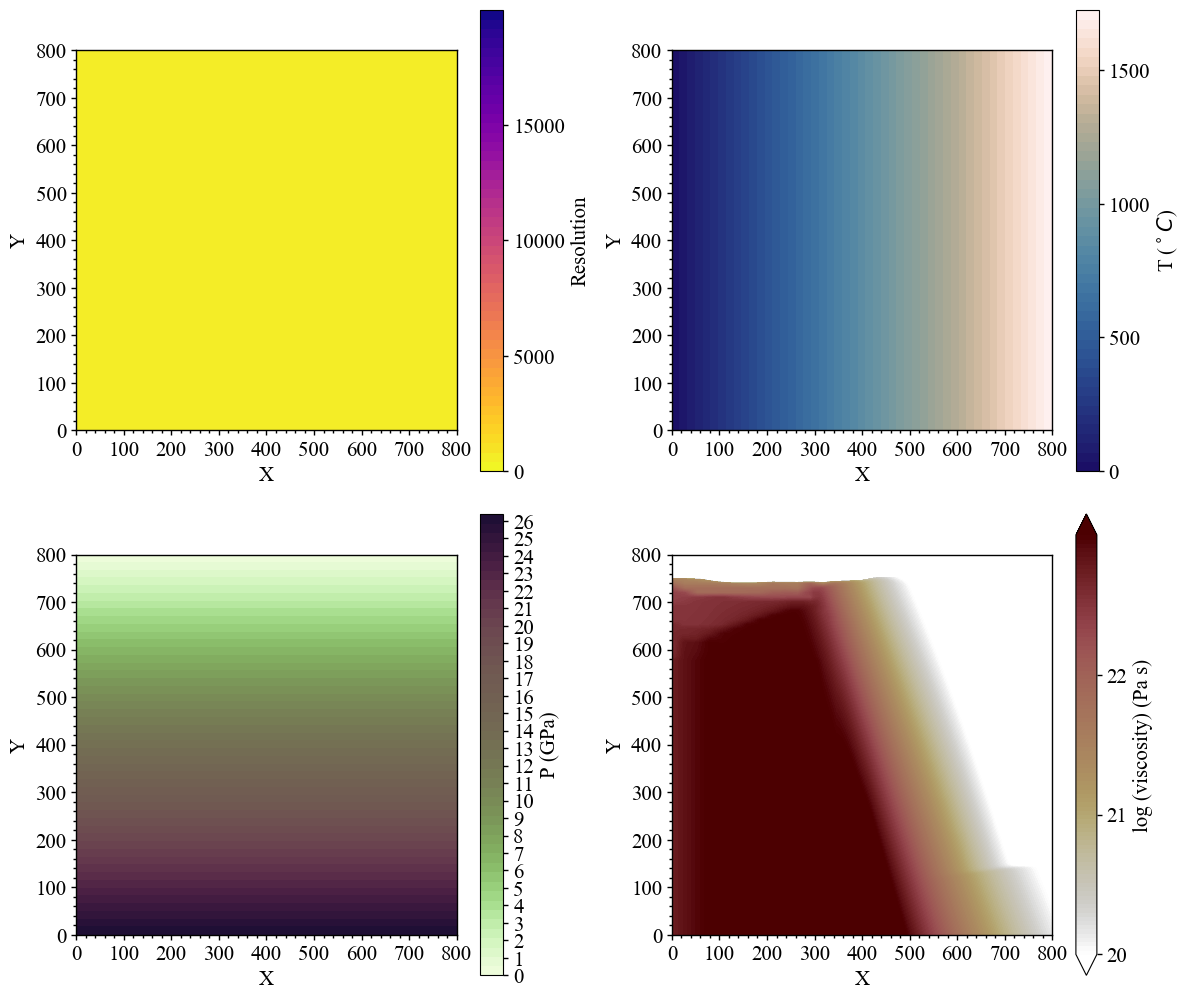

In [9]:
from matplotlib import rcdefaults
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from cmcrameri import cm as ccm

# Retrieve the default color cycle
default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

# Example usage
# Rule of thumbs:
# 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
# 2. Set five major ticks for each axis
scaling_factor = 1.0  # scale factor of plot
font_scaling_multiplier = 1.5 # extra scaling multiplier for font
legend_font_scaling_multiplier = 0.5
line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
x_lim = (0.0, 800)
x_tick_interval = 100   # tick interval along x
y_lim = (0.0, 800)
y_tick_interval = 100  # tick interval along y

resolution_lim = (0.0, 20e3) # resolution
resolution_level = 50  # number of levels in contourf plot
resolution_tick_interval = 5e3  # tick interval along v

T_lim = (0.0, 2000-273.15) # T
T_level = 50  # number of levels in contourf plot
T_tick_interval = 500.0  # tick interval along v

P_lim = (np.min(P_grid)/1e9, np.max(P_grid)/1e9) # P
P_level = 50  # number of levels in contourf plot
P_tick_interval = 1.0  # tick interval along v

visc_log10_lim = (20.0, 23.0)
visc_log10_level = 100
visc_log10_tick_interval = 1.0

n_minor_ticks = 4  # number of minor ticks between two major ones

# scale the matplotlib params
plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                        line_width_scaling_multiplier=line_width_scaling_multiplier)

# Update font settings for compatibility with publishing tools like Illustrator.
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Create a figure with a 2x2 grid layout
fig = plt.figure(figsize=(12, 15), tight_layout=True)
gs = gridspec.GridSpec(3, 2)

# Plot the mesh resolution
ax = fig.add_subplot(gs[0, 0])

levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

color_map = ax.contourf(x_grid/1e3, y_grid/1e3, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

ax.set_xlabel("X")
ax.set_ylabel("Y")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


# Plot T
ax = fig.add_subplot(gs[0, 1])

levels = np.linspace(T_lim[0], T_lim[1], T_level)
ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

color_map = ax.contourf(x_grid/1e3, y_grid/1e3, T_grid-273.15,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
cbar = fig.colorbar(color_map, ax=ax, label=r"T ($^\circ C$)")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

ax.set_xlabel("X")
ax.set_ylabel("Y")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

# Plot P
ax = fig.add_subplot(gs[1, 0])

levels = np.linspace(P_lim[0], P_lim[1], P_level)
ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

color_map = ax.contourf(x_grid/1e3, y_grid/1e3, P_grid/1e9,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
cbar = fig.colorbar(color_map, ax=ax, label="P (GPa)")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

ax.set_xlabel("X")
ax.set_ylabel("Y")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


# Plot viscosity
ax = fig.add_subplot(gs[1, 1])

levels = np.linspace(visc_log10_lim[0], visc_log10_lim[1], visc_log10_level)
ticks=np.arange(visc_log10_lim[0], visc_log10_lim[1], visc_log10_tick_interval)

color_map = ax.contourf(x_grid/1e3, y_grid/1e3, np.log10(visc_grid),\
                        vmin=visc_log10_lim[0], vmax=visc_log10_lim[1],\
                            levels=levels, cmap=ccm.bilbao_r, extend="both")  # Resolution colormap
cbar = fig.colorbar(color_map, ax=ax, label="log (viscosity) (Pa s)")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

ax.set_xlabel("X")
ax.set_ylabel("Y")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

if model == "perplex":
    fig_path = os.path.join(case_dir, "model_results_model_%s_mixing_%d_repetitions_%d.pdf" % (model, mixing_model, n_repetitions))
elif model == "CDPT":
    fig_path = os.path.join(case_dir, "model_results_model_%s_cutoff_%1fkm_repetitions_%d.pdf" % (model, cutoff_depth/1e3, n_repetitions))
else:
    raise ValueError("Model must be perplex or CDPT.")
fig.savefig(fig_path)

print("Saved figure %s" % fig_path)

# Reset rcParams to defaults
rcdefaults()

## Plot diagram

Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/TwoDSubduction_perplex/model_diagram_model_perplex_mixing_3_repetitions_800.pdf


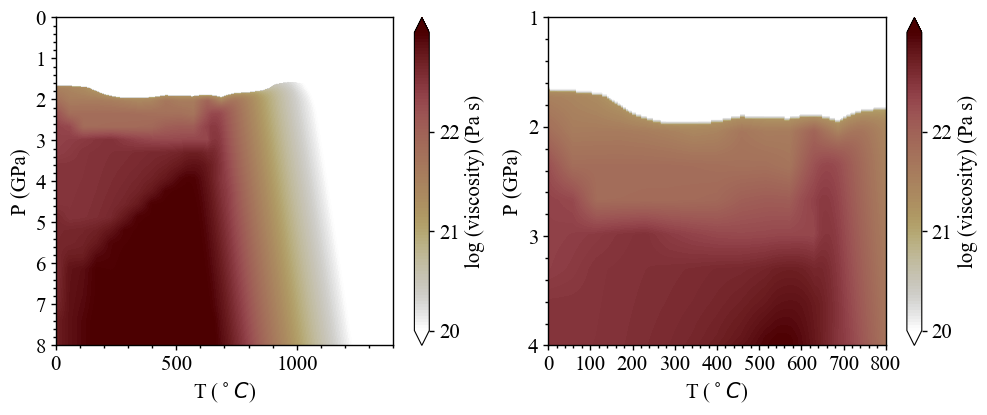

In [8]:
from matplotlib import rcdefaults
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from cmcrameri import cm as ccm

# Retrieve the default color cycle
default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

# Example usage
# Rule of thumbs:
# 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
# 2. Set five major ticks for each axis
scaling_factor = 1.0  # scale factor of plot
font_scaling_multiplier = 1.5 # extra scaling multiplier for font
legend_font_scaling_multiplier = 0.5
line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines

T_lim = (0.0, 1400.0) # T (C)
T_level = 50  # number of levels in contourf plot
T_tick_interval = 500.0  # tick interval along v

T_lim1 = (0.0, 800.0) # T (C), smaller scale
T_tick_interval1 = 100.0  # tick interval along x
P_lim1 = (1.0, 4.0) # P (Gpa)

P_lim = (0.0, 8.0) # P (Gpa)
P_level = 50  # number of levels in contourf plot
P_tick_interval = 1.0  # tick interval along v

visc_log10_lim = (20.0, 23.0)
visc_log10_level = 100
visc_log10_tick_interval = 1.0

n_minor_ticks = 4  # number of minor ticks between two major ones

# scale the matplotlib params
plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                        line_width_scaling_multiplier=line_width_scaling_multiplier)

# Update font settings for compatibility with publishing tools like Illustrator.
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Create a figure with a 2x2 grid layout
fig = plt.figure(figsize=(10, 4.25), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# Plot the diagram of viscosity
ax = fig.add_subplot(gs[0, 0])

levels = np.linspace(visc_log10_lim[0], visc_log10_lim[1], visc_log10_level)
ticks=np.arange(visc_log10_lim[0], visc_log10_lim[1], visc_log10_tick_interval)

color_map = ax.contourf(T_grid-273.15, P_grid/1e9, np.log10(visc_grid),\
                        vmin=visc_log10_lim[0], vmax=visc_log10_lim[1],\
                            levels=levels, cmap=ccm.bilbao_r, extend="both")  # Resolution colormap

cbar = fig.colorbar(color_map, ax=ax, label="log (viscosity) (Pa s)")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_xlim(T_lim)
ax.set_ylim(P_lim)

ax.xaxis.set_major_locator(MultipleLocator(T_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(T_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(P_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(P_tick_interval/(n_minor_ticks+1)))

ax.invert_yaxis()

ax.set_xlabel(r"T ($^\circ C$)")
ax.set_ylabel("P (GPa)")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

# Plot a zoom-in diagram of viscosity
ax = fig.add_subplot(gs[0, 1])

levels = np.linspace(visc_log10_lim[0], visc_log10_lim[1], visc_log10_level)
ticks=np.arange(visc_log10_lim[0], visc_log10_lim[1], visc_log10_tick_interval)

color_map = ax.contourf(T_grid-273.15, P_grid/1e9, np.log10(visc_grid),\
                        vmin=visc_log10_lim[0], vmax=visc_log10_lim[1],\
                            levels=levels, cmap=ccm.bilbao_r, extend="both")  # Resolution colormap

cbar = fig.colorbar(color_map, ax=ax, label="log (viscosity) (Pa s)")  # Add colorbar
cbar.set_ticks(ticks)

ax.set_xlim(T_lim1)
ax.set_ylim(P_lim1)

ax.xaxis.set_major_locator(MultipleLocator(T_tick_interval1))
ax.xaxis.set_minor_locator(MultipleLocator(T_tick_interval1/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(P_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(P_tick_interval/(n_minor_ticks+1)))

ax.invert_yaxis()

ax.set_xlabel(r"T ($^\circ C$)")
ax.set_ylabel("P (GPa)")

for spine in ax.spines.values():
    # Adjust spine thickness for this plot
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


if model == "perplex":
    fig_path = os.path.join(case_dir, "model_diagram_model_%s_mixing_%d_repetitions_%d.pdf" % (model, mixing_model, n_repetitions))
elif model == "CDPT":
    fig_path = os.path.join(case_dir, "model_diagram_model_%s_cutoff_%.1fkm_repetitions_%d.pdf" % (model, cutoff_depth/1e3, n_repetitions))
else:
    raise ValueError("Model must be perplex or CDPT.")

fig.savefig(fig_path)

print("Saved figure %s" % fig_path)

# Reset rcParams to defaults
rcdefaults()